In [107]:
from dotenv import load_dotenv
from langchain_ollama import ChatOllama
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from typing import TypedDict, Sequence, Annotated


import os

In [108]:


pdf_path = "Omar Mohamed - Data Scienctist new .pdf"

if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"File {pdf_path} not found")

try:
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()
    print("PDF loaded successfully and documents length is ", len(documents))
except Exception as e:
    print(f"Error loading PDF: {e}")


PDF loaded successfully and documents length is  2


In [109]:
llm = ChatOllama(model="mistral:latest")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [110]:
# text_splitter 
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print("Chunks length is ", len(chunks))

Chunks length is  29


In [113]:
collection_name = "rag_collection2"
try:
    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        persist_directory=collection_name,
    )
    print("Vectorstore created successfully")
except Exception as e:
    print(f"Error creating vectorstore: {e}")

Vectorstore created successfully


In [114]:
# retriever 
retriever = vectorstore.as_retriever(
    search_kwargs={"k": 3},
    search_type="similarity"
)


In [115]:
@tool
def retriver_tool(query: str) -> str:
    """Use this tool to search and return the most relevant documents from the vector store."""
    docs = retriever.invoke(query)
    if not docs:
        print("\n\nNo Docs Found \n\n")
        return "No documents found"
    
    results = []
    for i, doc in enumerate(docs):
        print(f"Source {i+1}: \n{doc.page_content}\nMetadata: {doc.metadata}")
        results.append(f"Source {i+1}: \n{doc.page_content}\nMetadata: {doc.metadata}")
    return "\n\n".join(results)


tools = [retriver_tool]
llm = llm.bind_tools(tools)

In [116]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [117]:
def should_continue(state: AgentState) -> bool:
    """ Check if the last message contains tool calls """
    result = state["messages"][-1]
    return hasattr(result, "tool_calls") and len(result.tool_calls) > 0

In [118]:
system_prompt = """
You answer questions about a CV/resume in the knowledge base. You MUST use the retriever_tool to get document content before answering.

RULES:
- For every user question, call retriever_tool first with a search query (e.g. the question or key terms). You may call it multiple times.
- Base your answer ONLY on the text returned by retriever_tool (in the ToolMessage). Do not use general knowledge or information about other people (even similar names).
- If the retrieved text does not contain the answer, say only: "That is not in the document."
- Do not add, guess, or infer. Do not mention any person, place, date, or fact unless it appears in the retriever results.
"""


In [ ]:
# Run retrieval first so the LLM always has document context (no chance to answer from memory)
def retrieve_first(state: AgentState) -> AgentState:
    """Get the user's last message, run retriever, and inject the result as a message."""
    messages = list(state["messages"])
    if not messages:
        return {"messages": [SystemMessage(content="RETRIEVED DOCUMENT (your only source):\n\nNo query provided.")]}
    last = messages[-1]
    query = getattr(last, "content", "") if hasattr(last, "content") else ""
    if not query or not isinstance(query, str):
        query = str(query)
    docs = retriever.invoke(query)
    if not docs:
        return {"messages": [SystemMessage(content="RETRIEVED DOCUMENT (your only source):\n\nNo documents found.")]}
    parts = [f"Source {i+1}:\n{doc.page_content}" for i, doc in enumerate(docs)]
    context = "\n\n---\n\n".join(parts)
    return {"messages": [SystemMessage(content="RETRIEVED DOCUMENT (your only source):\n\n" + context)]}

In [119]:
tool_dict = { out_tool.name : out_tool for out_tool in tools }

In [120]:
# Retriver Agent 
def take_action(state: AgentState) -> AgentState:
    """Function to execute tools from the LLM response"""
    tool_calls = state["messages"][-1].tool_calls
    if not tool_calls:
        return state
    results = []
    for t in tool_calls:
        print(f"Executing tool: {t['name']}")
        tool_name = t['name']
        if not tool_name in tool_dict:
            result = f"Tool {tool_name} not found"
            continue
        else:
            result = tool_dict[tool_name].invoke(t['args'])
            print(f"Tool {tool_name} called with arguments: {t['args']}")
            print(f"Tool {tool_name} returned: {result}")
        results.append(ToolMessage(content=result, name=tool_name, tool_call_id=t['id']))
    
    print("Tool calls executed")
    # Return flat list so add_messages appends each ToolMessage (not a nested list)
    return {"messages": results}




In [121]:
def call_llm(state: AgentState) -> AgentState:
    """Call the LLM (with tools) so it can call retriever_tool, then answer from the tool results."""
    messages = [SystemMessage(content=system_prompt)] + list(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [125]:
graph = StateGraph(AgentState)

graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_edge(START, "llm")
graph.add_conditional_edges("llm", should_continue, {True: "retriever_agent", False: END})
graph.add_edge("retriever_agent", "llm")


NameError: name 'retrieve_first' is not defined

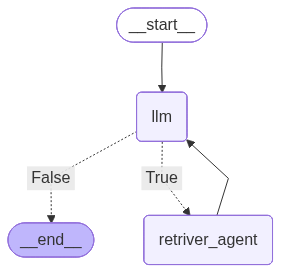

In [123]:
agent = graph.compile()
agent

In [124]:
def running_agent():
    while True:
        query = input("What is your question: ")
        if query.lower() in ["exit", "quit", "bye"]:
            print("Exiting the agent")
            break
        response = agent.invoke({"messages": [HumanMessage(content=query)]})
        print("Agent response:")
        print(response["messages"][-1].content)
        print("-"*100)

running_agent()

Agent response:
 I'm unable to provide a response without first searching for relevant documents using the `retriever_tool`. Could you please provide me with a specific query so I can search the knowledge base and return the most relevant documents?
----------------------------------------------------------------------------------------------------
Agent response:

----------------------------------------------------------------------------------------------------
Agent response:

----------------------------------------------------------------------------------------------------
Exiting the agent
